# Bias model bootstrapping notebook

Eventually this notebook will (hopefully?) contain all the code necessary to run our final experiments.
For now it just contains a demo of MCE IRL on some gridworlds from the "learning biases" paper.

First we have some not-very-interesting setup:

In [1]:
%matplotlib inline

# These are useful for debugging, but make code slower:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import jax.experimental.optimizers as jopt
import jax.random as jrandom
import numpy as np

from pref_bootstrap.envs import gridworld, mdp_interface
from pref_bootstrap.algos import mce_irl
import pref_bootstrap.feedback_learner_blind_irl as fbl_blind_irl
import pref_bootstrap.feedback_learner_paired_comparisons as fbl_paired_comp
import pref_bootstrap.reward_models as r_models
import pref_bootstrap.expert_base as experts

sns.set(context='notebook', style='darkgrid')
logging.basicConfig(level=logging.INFO)
np.set_printoptions(precision=4, linewidth=100)

## Very simple example of using environments and MCE IRL code

This code doesn't use the new agent API

In [2]:
random_gridworld = gridworld.GridworldMdp.generate_random(4, 4, 0.2, 0.1)
env = mdp_interface.GridworldEnvWrapper(random_gridworld, random_gridworld.height + random_gridworld.width)

In [3]:
# generate some optimal demos (represented by a single optimal occupancy measure vector) and run MCE IRL
_, optimal_om = mce_irl.mce_occupancy_measures(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
opt_tup = jopt.momentum(1e-2, 0.9)

In [4]:
rew_params, visitations = mce_irl.mce_irl(env, opt_tup, rmodel, optimal_om, print_interval=100, max_iter=1000)

INFO:root:Occupancy measure error@iter   0: 5.120719 (||params||=5.464185, ||grad||=7.188662, ||E[dr/dw]||=5.474283)
INFO:root:Occupancy measure error@iter  100: 0.074027 (||params||=5.532739, ||grad||=0.097902, ||E[dr/dw]||=7.004508)
INFO:root:Occupancy measure error@iter  200: 0.016216 (||params||=5.258959, ||grad||=0.020016, ||E[dr/dw]||=6.945628)
INFO:root:Occupancy measure error@iter  300: 0.005753 (||params||=5.241966, ||grad||=0.007494, ||E[dr/dw]||=6.939545)
INFO:root:Occupancy measure error@iter  400: 0.002843 (||params||=5.245634, ||grad||=0.003551, ||E[dr/dw]||=6.940188)
INFO:root:Occupancy measure error@iter  500: 0.001429 (||params||=5.248060, ||grad||=0.001740, ||E[dr/dw]||=6.940674)


In [5]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))
print('\nRecovered state visitation frequencies for each grid cell:')
print(visitations.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.2728e-03 4.6748e-02 0.0000e+00]
 [0.0000e+00 1.0985e+00 6.8535e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]

Recovered state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.0600e-03 4.7747e-02 0.0000e+00]
 [0.0000e+00 1.0979e+00 6.8533e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


## More complex example showing how to use an EnvFeedbackModel to recover both a reward function + sub-rationality model

This code actually does use the new API to show how to use the 'blind IRL' feedback model (& its associated expert, which doesn't support observation blinding yet).

In [6]:
# ALRIGHT, HERE IS WHERE I WILL DEBUG THE TOPK FEEDBACK LEARNER
# ABLATIONS: COULD WE DO BETTER IF ALL OUR TRAJECTORIES ARE GOOD? 
# OR IS IT NECESSARY TO HAVE BAD TRAJECTORIES? 

In [7]:
import pref_bootstrap.feedback_learner_topk as fbl_topk

rmodel = r_models.LinearRewardModel(env.obs_dim)
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.3, K=.05, seed=42)

In [8]:
# def genereate_top_K_dataset(n_traj): 
import random

n_traj = 1000
traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
labels= top_K_expert.interact(traj)

labels_final, traj_final = [], []
for l, t in zip(labels, traj['states']): 
    if not(l):
        if True:#random.random() < (np.sum(labels)/len(labels)):
            labels_final.append(l), traj_final.append(t)
    else: 
        labels_final.append(l), traj_final.append(t)
        
labels_final = np.array(labels_final)
        
print(np.sum(labels)/len(labels))
print(np.sum(labels_final)/len(labels_final))


cutoff 18.0
0.066
0.066


In [9]:
def generate_topk_dataset(n_traj):
    # def genereate_top_K_dataset(n_traj): 
    import random
    traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
    labels= top_K_expert.interact(traj)

    labels_final, traj_final = [], []
    for l, t in zip(labels, traj['states']): 
        if not(l):
            if random.random() < top_K_expert.K:#TODO if there are issues update this so that we balance our dataset.
                labels_final.append(l), traj_final.append(t)
        else: 
            labels_final.append(l), traj_final.append(t)

    labels_final = np.array([int(l) for l in labels_final])
    
    return {
        'trajectories':np.array(traj_final), 
        'labels':labels_final
    }

top_K_dataset = generate_topk_dataset(10000)


cutoff 18.0


In [10]:
lr = 1e-3
steps = 10000
loss_prev = float('Inf')
delta = 100
eps = 1e-5

import pref_bootstrap.feedback_learner_topk as fbl_topk
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.3, K=.05, seed=42)
rmodel = r_models.LinearRewardModel(env.obs_dim)
import jax
import jax.numpy as jnp

rng = jrandom.PRNGKey(42)
rng, top_K_bias_params = top_K_feedback_model.init_bias_params(rng)

In [11]:
lr = 1e-2
steps = 1000
loss_prev = float('Inf')
delta = 100
eps = 1e-5

step = 0
while(np.abs(delta) > eps and step<steps):
    loss, gradients = top_K_feedback_model.normal_grad(top_K_dataset, rmodel, top_K_bias_params)
    if step % 100 == 0:
        print('step %d loss %.3f' %(step, loss))
    if step > 0: 
        delta = loss-loss_prev
    loss_prev = loss
    step +=1
                       
    gbias = gradients[0]
    grew = gradients[1]
                 
    new_r = rmodel.get_params() + lr*grew
    rmodel.set_params(new_r)
    
    new_b = top_K_bias_params + lr*gbias
if np.abs(delta) <= .0001: 
    print('terminated due to delta')
else: 
    print('terminated due to steps exceeding %d' %steps)

step 0 loss -1.539
step 100 loss -1.016
step 200 loss -0.749
step 300 loss -0.579
step 400 loss -0.482
step 500 loss -0.431
step 600 loss -0.405
step 700 loss -0.391
step 800 loss -0.384
step 900 loss -0.380
terminated due to delta


[0.7808 0.1291]


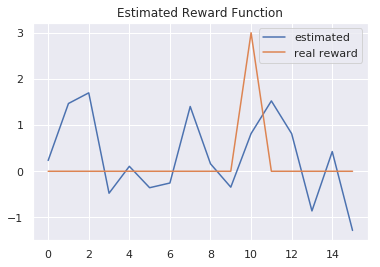

In [12]:
plt.plot(rmodel.get_params(), label='estimated')
plt.plot(env.reward_matrix, label='real reward')
plt.legend()
plt.title('Estimated Reward Function')
print(top_K_bias_params)

In [13]:
_, topk_om = mce_irl.mce_occupancy_measures(env, R=rmodel.get_params())

In [14]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.2728e-03 4.6748e-02 0.0000e+00]
 [0.0000e+00 1.0985e+00 6.8535e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


In [15]:
print('Inferred w. Top K')
print(topk_om.reshape((random_gridworld.height, random_gridworld.width)))

Inferred w. Top K
[[0.     0.     0.     0.    ]
 [0.     0.1133 0.4404 0.    ]
 [0.     1.7794 5.6669 0.    ]
 [0.     0.     0.     0.    ]]
